<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/pets_dens_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb

In [4]:
from ipdb import set_trace as st

In [5]:
from fastai import *
from fastai.vision import *

In [ ]:
'''
1. Prepare databunch
2. run a basic conv neetwork
3. resnet arch
4. dens net arch
'''

In [6]:
path = untar_data(URLs.PETS)

In [7]:
len((path/'images').ls())

7393

In [8]:
(path/'images').ls()[0].stem.rsplit('_', 1)[0]

'leonberger'

In [9]:
def get_label(im_path):
  return im_path.stem.rsplit('_', 1)[0]

In [10]:
from fastai.vision.data import ImageList
im_list = ImageList.from_folder(path/'images')

In [9]:
im_list

ImageList (7390 items)
Image (3, 375, 500),Image (3, 333, 500),Image (3, 333, 500),Image (3, 282, 500),Image (3, 500, 375)
Path: /root/.fastai/data/oxford-iiit-pet/images

In [11]:
im_list_split = im_list.split_by_rand_pct()
im_list_split

ItemLists;

Train: ImageList (5912 items)
Image (3, 375, 500),Image (3, 333, 500),Image (3, 333, 500),Image (3, 282, 500),Image (3, 500, 375)
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: ImageList (1478 items)
Image (3, 869, 600),Image (3, 500, 424),Image (3, 500, 333),Image (3, 500, 326),Image (3, 224, 300)
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

In [12]:
labeled_data = im_list_split.label_from_func(get_label)
labeled_data

LabelLists;

Train: LabelList (5912 items)
x: ImageList
Image (3, 375, 500),Image (3, 333, 500),Image (3, 333, 500),Image (3, 282, 500),Image (3, 500, 375)
y: CategoryList
leonberger,saint_bernard,wheaten_terrier,samoyed,Siamese
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 869, 600),Image (3, 500, 424),Image (3, 500, 333),Image (3, 500, 326),Image (3, 224, 300)
y: CategoryList
Abyssinian,Siamese,Russian_Blue,yorkshire_terrier,pug
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

In [13]:
data  = labeled_data.transform(get_transforms(), size = 352).databunch(bs = 32).normalize()

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


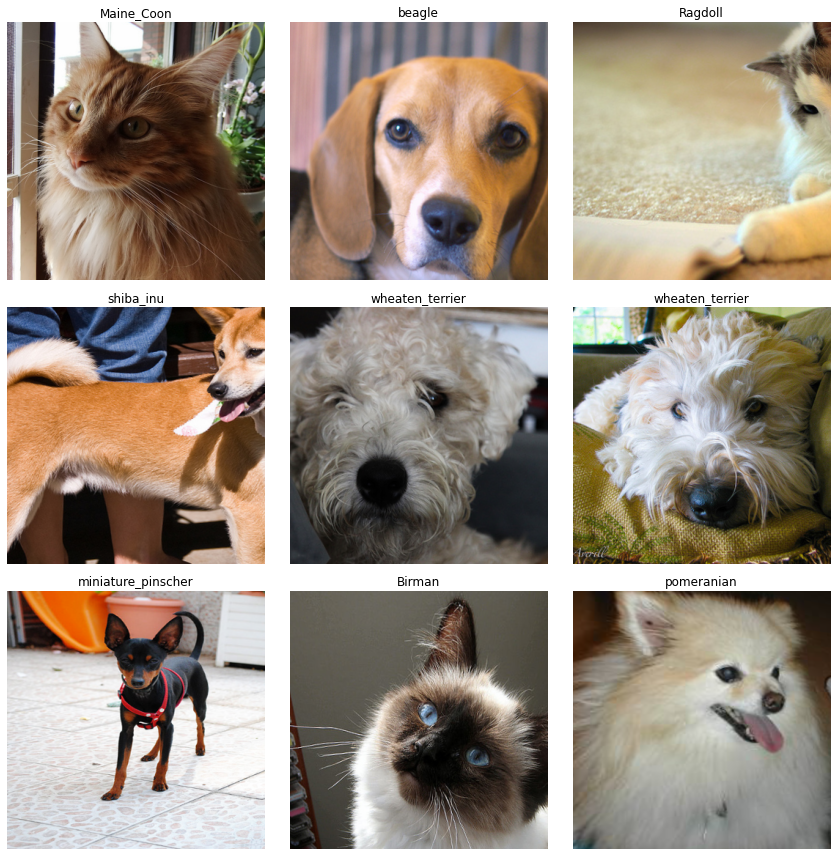

In [14]:
data.show_batch(rows = 3)

In [15]:
x, y = next(iter(data.valid_dl))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


In [16]:
img = x[0]
img.shape

torch.Size([3, 352, 352])

In [ ]:
# Creating a basic conv

In [17]:
data.c

37

In [37]:
nn.MaxPool2d(2, 2)(x).shape, x.shape

(torch.Size([32, 3, 176, 176]), torch.Size([32, 3, 352, 352]))

In [18]:
class SqAdaptiveAvgPool(nn.Module):
  def __init__(self):
    super().__init__()
    self.pool = nn.AdaptiveAvgPool2d(1)
  
  def forward(self, inp):
    return self.pool(inp).squeeze()

In [19]:
class ResBlock(nn.Module):
  def __init__(self, ni, dens = False):
    super().__init__()
    self.c1 = cbr(ni, ni, ks = 3, stride = 1)
    self.c2 = cbr(ni, ni, ks = 3, stride = 1)
    self.dens = dens
    self.layer = nn.Sequential(self.c1, self.c2)

  def forward(self, x):
    if (self.dens):
      return torch.cat([self.layer(x), x], dim = 1)
    
    return self.layer(x) + x

In [20]:
def cbr(ni, nf, ks = 3, stride = 2):
  return nn.Sequential(nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding_mode='reflect', padding = 1), nn.BatchNorm2d(nf), nn.ReLU())

In [21]:
def conv_res(ni, nf, ks = 3, dens = False):
  return nn.Sequential(conv_layer(ni, nf, ks), ResBlock(nf, dens = dens))

In [22]:
def conv_layer(ni, nf, ks = 3):
  return nn.Sequential(nn.Conv2d(ni, nf, kernel_size = ks, stride = 2), nn.BatchNorm2d(nf), nn.ReLU(), nn.Conv2d(nf, nf, kernel_size = 3, stride = 1), nn.BatchNorm2d(nf), nn.ReLU())

In [23]:
arch = nn.Sequential(
    conv_res(3, 16, ks = 7, dens = True), #32, 172, 172 -- 0
    conv_res(32, 64, ks = 3, dens = True), # 128, 83, 83 -- 1
    conv_res(128, 256, ks = 3, dens = True), # 512, 39, 39 -- 2
    conv_res(512, 1024, ks = 3, dens = True), # 1024, 19, 19 -- 3
    nn.MaxPool2d(2, 2),
    SqAdaptiveAvgPool(),
    nn.Linear(2048, 1000),
    nn.BatchNorm1d(1000),
    nn.ReLU(),
    nn.Linear(1000, data.c),
    nn.BatchNorm1d(data.c),
).cuda()

In [24]:
gc.collect()

20847

In [25]:
yhat = arch(x)
yhat.shape

torch.Size([32, 37])

In [26]:
def my_accuracy(yhat, y):
  preds = yhat.argmax(1)
  mask = preds == y
  train_acc = torch.sum(mask)
  return (train_acc/y.shape[0])*100

In [29]:
my_accuracy(yhat, y)

tensor(9.3750, device='cuda:0')

In [27]:
learn = Learner(data, arch, metrics = my_accuracy, wd = 1e-02)

In [28]:
import warnings
warnings.filterwarnings("ignore")

epoch,train_loss,valid_loss,my_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


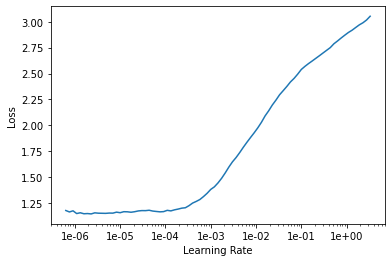

In [99]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, max_lr = 2e-04)

epoch,train_loss,valid_loss,my_accuracy,time
0,3.424987,3.431804,10.622463,00:39
1,3.261015,3.341208,13.531799,00:39
2,3.061131,2.967996,16.373478,00:39
3,2.862974,3.286265,11.772666,00:39
4,2.682549,2.823615,24.086603,00:39
5,2.484823,2.568146,27.401894,00:39
6,2.325013,2.315884,34.573750,00:39
7,2.134976,1.963334,44.925575,00:39
8,2.047604,1.800550,51.150204,00:39
9,1.971646,1.780233,52.503384,00:39


In [32]:
learn.save('st_1')

In [35]:
learn.load('st_1')
learn.fit_one_cycle(10, max_lr = 7e-05)

epoch,train_loss,valid_loss,my_accuracy,time
0,1.972824,1.844019,50.608932,00:39
1,1.995831,1.977103,43.640053,00:39
2,2.006752,1.984481,44.857918,00:39
3,1.963738,1.985985,44.519623,00:39
4,1.880134,1.716075,52.571041,00:39
5,1.782715,1.705606,53.788902,00:39
6,1.723426,1.519987,58.728012,00:39
7,1.596267,1.448532,61.637348,00:39
8,1.539294,1.386890,63.261166,00:40
9,1.522096,1.375235,65.358589,00:39


In [38]:
learn.save('st_2')

In [75]:
# Try 
# 1. Freezing early layers and training - cant run this now because we do not have multiple layer groups
# 2. Discriminative learning rates to early layers

# In this cell, lets do freezing first two layers and train

learn.unfreeze()
learn.load('st_2')
learn.fit_one_cycle(10, max_lr = 1e-05)

epoch,train_loss,valid_loss,my_accuracy,time
0,1.509681,1.367068,64.546684,00:39
1,1.505913,1.364143,63.193504,00:39
2,1.501814,1.395102,62.922871,00:39
3,1.499080,1.372088,64.208389,00:39
4,1.482118,1.338474,65.358589,00:39
5,1.456942,1.341156,66.170502,00:39
6,1.444221,1.292718,66.711769,00:39
7,1.452392,1.306749,66.576454,00:39
8,1.408795,1.287749,67.929634,00:39
9,1.429583,1.280016,67.320702,00:39


In [90]:
learn.save('st_3')

In [93]:
learn.load('st_3')
learn.fit_one_cycle(10, max_lr = 4e-5)

epoch,train_loss,valid_loss,my_accuracy,time
0,1.438824,1.320861,66.035179,00:39
1,1.522961,1.518227,59.675236,00:39
2,1.536870,1.566978,59.404602,00:39
3,1.546435,1.485945,61.840324,00:39
4,1.494164,1.453331,61.366711,00:39
5,1.419254,1.309742,65.087959,00:39
6,1.312231,1.240549,69.891747,00:39
7,1.288574,1.167778,72.056831,00:39
8,1.253854,1.142369,72.124489,00:39
9,1.217981,1.154076,71.109604,00:39


In [95]:
learn.save('st_4')

In [97]:
learn.load('st_4')
learn.fit_one_cycle(10, max_lr = 1e-5)

epoch,train_loss,valid_loss,my_accuracy,time
0,1.207675,1.149592,71.447899,00:39
1,1.221193,1.165707,70.230042,00:39
2,1.256624,1.171069,71.177269,00:39
3,1.247609,1.197584,70.297699,00:39
4,1.191326,1.186645,72.259811,00:39
5,1.212753,1.155336,71.718536,00:39
6,1.205530,1.129504,72.192154,00:39
7,1.157633,1.107629,73.071716,00:39
8,1.186742,1.120042,73.342354,00:39
9,1.135358,1.119930,73.071716,00:39


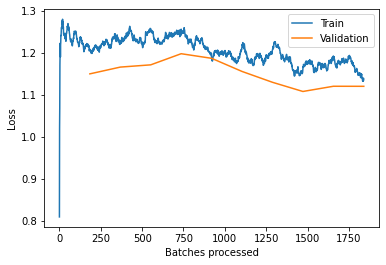

In [98]:
learn.recorder.plot_losses()

In [100]:
learn.save('st_5')

In [101]:
learn.load('st_5')
learn.fit_one_cycle(15, max_lr = 5e-06)

epoch,train_loss,valid_loss,my_accuracy,time
0,1.175769,1.117800,73.410011,00:39
1,1.169393,1.129339,72.395126,00:39
2,1.169334,1.128034,72.124489,00:39
3,1.164577,1.122943,72.395126,00:39
4,1.140954,1.146607,71.312584,00:39
5,1.113410,1.120308,72.124489,00:39
6,1.147356,1.133422,72.665764,00:39
7,1.134573,1.107432,73.207039,00:39
8,1.112557,1.119822,73.612991,00:39
9,1.126067,1.114840,72.665764,00:39


In [102]:
learn.save('st_6')

In [82]:
x, y = next(iter(data.valid_dl))
x[0][None].shape

torch.Size([1, 3, 352, 352])

In [ ]:
stats = data.batch_stats()

In [47]:
batch = x[11][None]

In [ ]:
batch.shape

torch.Size([1, 3, 352, 352])

In [48]:
white_plane = Image(torch.ones(3, 352, 352))

In [84]:
def show_heatmap(img, hm):
    _,ax = plt.subplots()
    img.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352, 352,0),
               interpolation='bilinear', cmap='magma');

In [103]:
model = learn.model
# model

In [86]:
yhat = model(x)

In [104]:
from fastai.callbacks.hooks import hook_output
with hook_output(model[0]) as hooked_op_0:
  with hook_output(model[1]) as hooked_op_1:
    with hook_output(model[2]) as hooked_op_2:
      with hook_output(model[3]) as hooked_op_3:
        with hook_output(model[4]) as hooked_op_4:
          yhat = model(x)

In [88]:
# Function to show the data of each layer
def show(image, hooked, index = 0):

  acts = hooked.stored[index]
  heat = acts.mean(0)
  show_heatmap(image, heat.cpu())

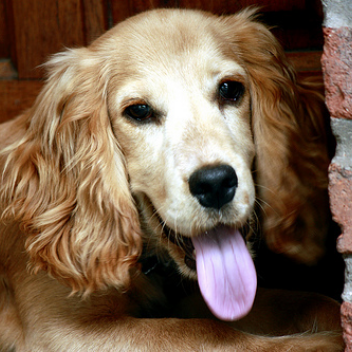

In [116]:
img = data.denorm(x[10])
image = Image(img)
image

(None, None)

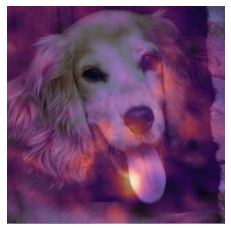

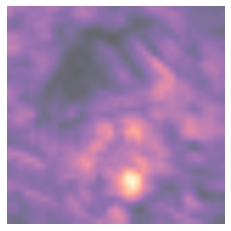

In [119]:
show(image, hooked_op_2, index = 13), show(white_plane, hooked_op_2, index = 13)

In [120]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (1): ResBlock(
      (c1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (c2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (layer): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 16, kernel_siz

In [121]:
len(learn.layer_groups)

1